In [1]:
import os
from googleapiclient.discovery import build as build_api_client

In [2]:
assert 'YOUTUBE_API_KEY' in os.environ
yt = build_api_client('youtube', 'v3', developerKey=os.environ['YOUTUBE_API_KEY'])

In [3]:
def load_categories_from_api(video_ids):
    request = yt.videos().list(
        part='snippet',
        id=','.join(video_ids)
    )
    response = request.execute()
    return {item['id']: item['snippet']['categoryId'] for item in response['items']}

In [4]:
import numpy as np
import pandas as pd
import tqdm.notebook
from loaders import load_semi_supervised, load_categories

tqdm.notebook.tqdm()
df = load_semi_supervised()
categories = load_categories()

In [5]:
api_categories_file = '../youtube_data/api_categories.csv'

if not os.path.exists(api_categories_file):
    api_df = pd.DataFrame(data={ 'video_id': df['video_id'] })
    api_df['api_category_id'] = -1
    unknown_ids = df[df['dataset_category_id'].isnull()]['video_id']

    print(len(unknown_ids))

    def chunker(seq, size):
        return (seq[pos:pos + size] for pos in range(0, len(seq), size))

    categories_dict = {}

    videos_per_query = 20
    for chunk in tqdm.tqdm(chunker(unknown_ids, videos_per_query), total=len(unknown_ids)/videos_per_query):
        video_ids = list(chunk)
        response = load_categories_from_api(video_ids)
        categories_dict.update(response)
        for vid, category in response.items():
            api_df.loc[api_df['video_id'] == vid, 'api_category_id'] = int(category)
    
    api_df.to_csv(api_categories_file, index=False)

In [6]:
api_categories = pd.read_csv(api_categories_file).set_index('video_id')
df = df.join(api_categories, on='video_id')
df

,video_id,predicted_category_id,dataset_category_id,api_category_id
0,Jw1Y-zhQURU,26,NaN,-1
1,3s1rvMFUweQ,24,NaN,-1
2,n1WpP7iowLc,10,NaN,10
3,PUTEiSjKwJU,22,NaN,17
4,rHwDegptbI4,24,NaN,-1
...,...,...,...,...
8602,Gi56dSh8Fq8,26,NaN,22
8603,dS5Thrl-4Kc,26,NaN,26
8604,JGm9Y_hFqNk,20,NaN,17
8605,mpnshdmtE2Y,26,NaN,26


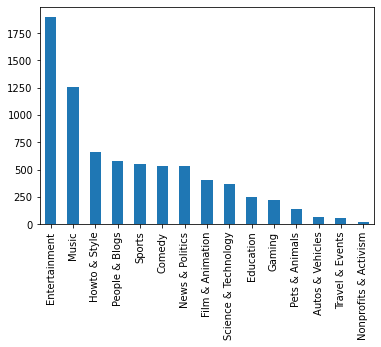

In [7]:
known = df[df['api_category_id'] > -1]

counts = known['api_category_id'].value_counts()
counts.index = [categories[str(ctg_id)] for ctg_id in counts.index]
counts.plot.bar()

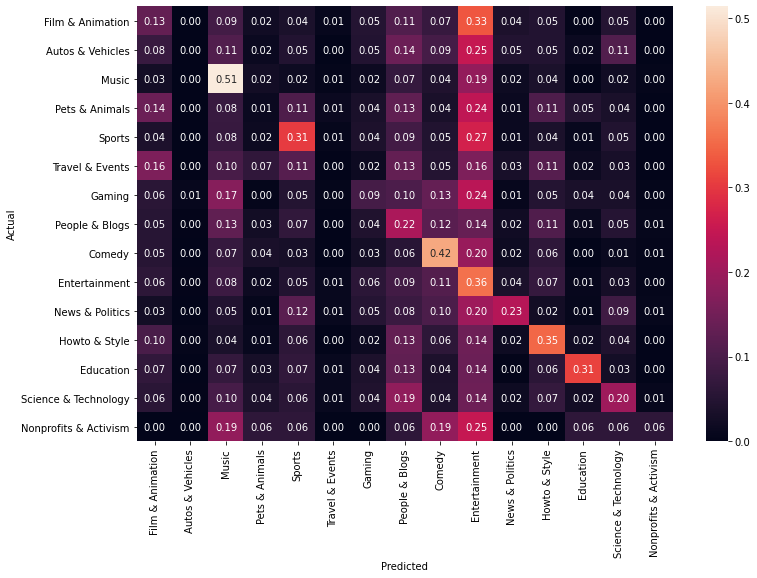

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

ctg_ids = [int(ctg) for ctg in categories.keys() if (known['api_category_id'] == int(ctg)).any()]
labels = [categories[str(ctg)] for ctg in ctg_ids]

conf = confusion_matrix(known['api_category_id'], known['predicted_category_id'], normalize='true', labels=ctg_ids)
plt.figure(figsize=(12, 8))
sns.heatmap(conf, annot=True, xticklabels=labels, yticklabels=labels, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [9]:
from sklearn.metrics import classification_report

print(classification_report(known['api_category_id'], known['predicted_category_id'], labels=ctg_ids, target_names=labels))

                       precision    recall  f1-score   support

     Film & Animation       0.12      0.13      0.12       401
     Autos & Vehicles       0.00      0.00      0.00        64
                Music       0.56      0.51      0.53      1255
       Pets & Animals       0.01      0.01      0.01       141
               Sports       0.32      0.31      0.31       554
      Travel & Events       0.00      0.00      0.00        61
               Gaming       0.07      0.09      0.08       224
       People & Blogs       0.16      0.22      0.18       582
               Comedy       0.29      0.42      0.34       535
        Entertainment       0.38      0.36      0.37      1896
      News & Politics       0.42      0.23      0.30       534
        Howto & Style       0.36      0.35      0.35       658
            Education       0.48      0.31      0.38       253
 Science & Technology       0.21      0.20      0.21       367
Nonprofits & Activism       0.03      0.06      0.04  